<a href="https://colab.research.google.com/github/BBrain778/BBrain778/blob/main/Step1_example_fastaiv2_data_prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1 安裝套件(若在colab訓練每次都需要執行)

In [ ]:
!pip install fastbook -q

## 1.2 讀取套件

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import shutil
import fastai;
print('fastai verison:', fastai.__version__)
print('torch version:', torch.__version__)

fastai verison: 2.7.18
torch version: 2.5.1+cu124



## 1.3 準備資料集

In [ ]:
#將 Google Drive 掛載到 /content/drive，以便存取或保存檔案
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#set project name
project = 'demo'

path = Path('/content/drive/MyDrive/DeepLearning/0225/dataset/'+project)

#Key is the name of classes; value is the keyword that which search engine uses for searching
keywords = {'elephant': 'elephant', 'giraffe': 'giraffe', 'hippo': 'hippo', 'monkey': 'monkey', 'zebra': 'zebra'}
array = keywords.items()

project_folder = f'/content/drive/MyDrive/DeepLearning/0225/dataset/{project}'

In [ ]:
if not path.exists():
    !mkdir -p {project_folder}
else:
    print('The Project Folder exists; it will be removed and created again.')
    shutil.rmtree(project_folder)
    !mkdir -p {project_folder}

#網路爬蟲下載圖片
for key,value in array:
    print(key,value)
    dest = (path/key)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f' {value}',max_images=100)
    download_images(dest, urls=urls)

The Project Folder exists; it will be removed and created again.
elephant elephant
giraffe giraffe
hippo hippo
monkey monkey
zebra zebra


## 1.4 清洗資料

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink) #unlink broken images

(#17) [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]

## 2.1 設定訓練資料路徑

In [ ]:
path = Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo')
path.ls()

(#5) [Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/elephant'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/giraffe'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/hippo'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/monkey'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/zebra')]

In [ ]:
#建立模型權重儲存路徑
myPath='/content/drive/MyDrive/DeepLearning/0225/models'
!mkdir -p $myPath

## 2.2 資料讀取框架

In [ ]:
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #定義輸入和輸出的資料類型(輸入:圖片/輸出:分類標籤)
    get_items=get_image_files,  #告訴 fastai 如何獲取資料
    splitter=RandomSplitter(valid_pct=0.2, seed=42),#20%的資料用於驗證集，剩下的80%用於訓練集
    item_tfms=Resize(224),#將所有圖片調整為 224x224 像素
    get_y=parent_label,#從圖片的父資料夾名稱獲取標籤
)

#利用框架正式讀取資料
# 批次大小（batch size），每次訓練或驗證時處理 16 張圖片
# 使用 16 個工作線程來並行載入資料，加快資料準備速度（特別在 GPU 環境中很有用）
dls = dataset.dataloaders(path,bs=16,num_workers=16)

#讀取結果
print(dls.c, dls.vocab, len(dls.train_ds), len(dls.valid_ds)) #dls.c=類別數量(5) dls.vocab=標籤詞彙表 len(dls.train_ds)=訓練樣本數量(80%) len(dls.valid_ds)=驗證數量(20%)



5 ['elephant', 'giraffe', 'hippo', 'monkey', 'zebra'] 364 91


## 2.3 讀取圖檔結果

訓練資料


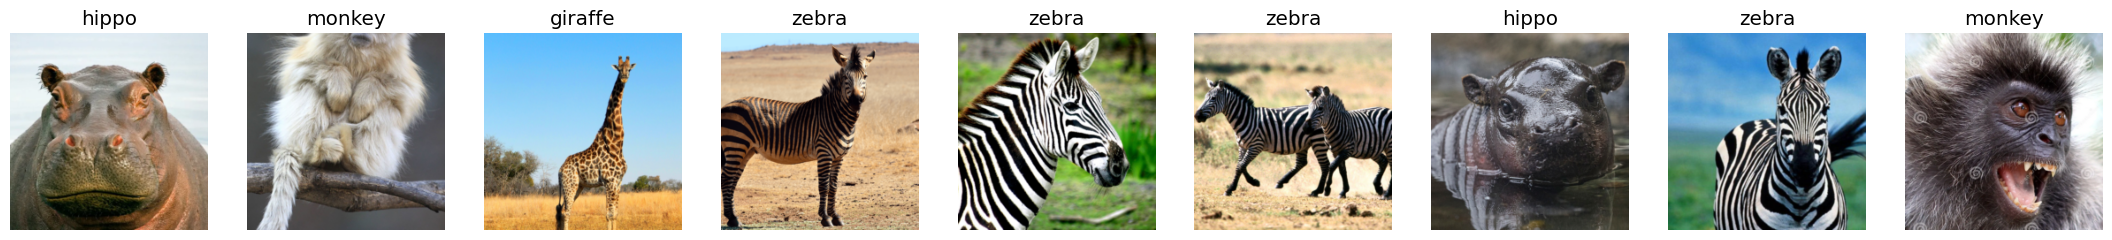

In [ ]:
print('訓練資料')
dls.show_batch(max_n=9, nrows=1) #從訓練集中抽出9個樣本   nrows=顯示的行數
#這邊顯示出來的圖片和標籤是我提供給fastai的資料，不是模型自己預測的結果


## 3.1選擇模型架構以及對應的預測訓練權重

NOTE: metrics是模型訓練人員觀察的指標，可設定多個

In [ ]:
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate], pretrained=True)
learn.fit_one_cycle(3, 1e-3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 144MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.410818,0.075914,0.978022,0.021978,00:29
1,0.606849,0.036833,0.989011,0.010989,00:27
2,0.343716,0.032743,0.989011,0.010989,00:30


## 3.2儲存第一次訓練好的權重

In [ ]:
myModel=myPath+'/resnet_stage-1.pkl'
learn.export(myModel)

## 3.3解凍權重再次訓練

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Minimum/10: 3.02e-06, steepest point: 1.10e-06


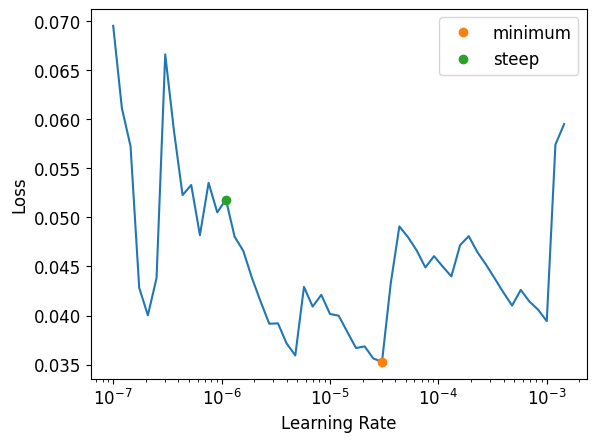

In [ ]:
learn.unfreeze()
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep), end_lr=10, num_it=100)
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn.fit_one_cycle(6, lr_max=2.75e-04)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.051793,0.015356,1.000000,0.000000,00:32
1,0.119166,0.193923,0.945055,0.054945,00:27
2,0.319800,0.191345,0.945055,0.054945,00:27
3,0.322353,0.127707,0.956044,0.043956,00:28
4,0.236193,0.110039,0.967033,0.032967,00:29
5,0.204724,0.104296,0.978022,0.021978,00:28


## 3.4儲存新的權重

In [ ]:
myModel=myPath+'/resnet_stage-2.pkl'
learn.export(myModel)

## 4.1結果檢核(Confusion Matrix)

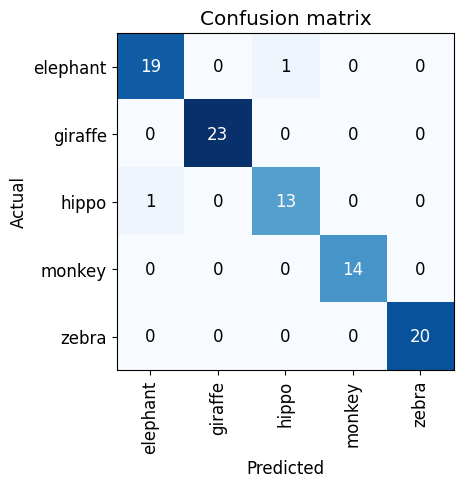

In [ ]:
#contains interpretation methods for classification models
interp = ClassificationInterpretation.from_learner(learn)
#Plot the confusion matrix
interp.plot_confusion_matrix()

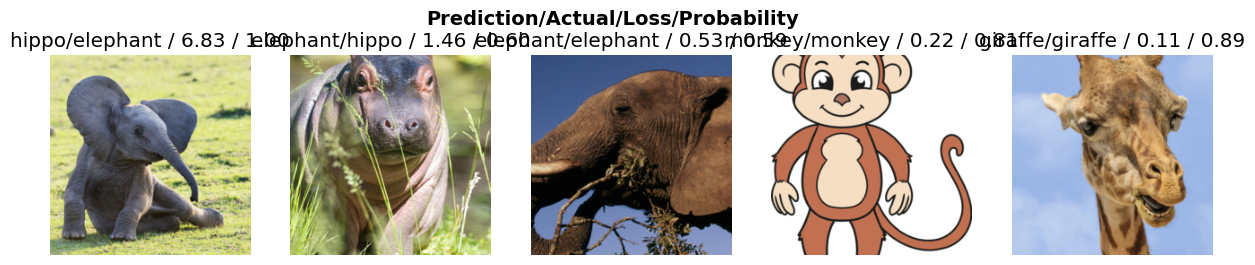

In [ ]:
interp.plot_top_losses(5, nrows=1)

## 預測

In [ ]:
## 模型位置
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 5.1讀取先前訓練好的權重

In [ ]:
myPath='/content/drive/MyDrive/DeepLearning/0225/models'
myModel=myPath+'/resnet_stage-2.pkl'
learn = load_learner(myModel)

## 5.2讀取檔案並送入模型預測

In [ ]:
##執行預測 -method I
fnames_elephant = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/elephant')
fnames_giraffe = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/giraffe')
fnames_hippo = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/hippo')
fnames_monkey = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/monkey')
fnames_zebra = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/zebra')


print(len(fnames_elephant))

89


In [ ]:
pred_class,pred_idx,outputs = learn.predict(fnames_elephant[3])
print("Actual: elephant, Predicted = {}".format(pred_class))

pred_class,pred_idx,outputs = learn.predict(fnames_elephant[7])
print("Actual: giraffe, Predicted = {}".format(pred_class))